  # Autoencoder Training - Baseline mode

# Setup

In [1]:
# %pwd
# %cd ~/WSL-shared/Cellpainting/pt-snnl/
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        # print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from typing import Dict, List, Tuple


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary
import wandb


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-BASE-MAIN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.set_num_threads(4)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


4

In [7]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace
import snnl.utils as utils

# from snnl.utils import load_model, save_model, import_results, export_results
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import display_model_summary, define_autoencoder_model, init_resume_training
from snnl.utils import save_checkpoint_v5, load_checkpoint_v5
from snnl.utils import plot_model_parms, plot_train_history, plot_classification_metrics, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import define_autoencoder_model, init_resume_training

from snnl.models import Model
from snnl.models import DNN 
from snnl.models import Autoencoder
from snnl.losses import SNNLoss

In [8]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
# logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-23 19:42:42,633 - __main__ - INFO: -  Excution started : 2024_09_23_19:42:42 
2024-09-23 19:42:42,634 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 4
2024-09-23 19:42:42,636 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


### main(args)

In [9]:
GPU_ID = 1
LATENT_DIM    = 150
HIDDEN_1      = 512
EPOCHS        = 100
LEARNING_RATE = 1.00e-03
# TEMP          = 1.00
# TEMP_LR       = 0.00   ##1.0e-05
# SNNL_FACTOR   = 3.0

COMPOUNDS_PER_BATCH = 600
ADAM_WEIGHT_DECAY = 0.001

# LOAD_EPOCH = 100
# RUN_DATETIME = "20240917_2017"
# CHECKPT = f"AE_base_scpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{RUN_DATETIME}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# RUN_ID        = "pbx3lu17"
# print(CHECKPT)

In [11]:
# if __name__ == "__main__":
cli_args = f" --runmode             baseline" \
            f" --configuration      hyperparameters/ae_baseline_{LATENT_DIM:03d}_{HIDDEN_1}_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --single_loss        "\
            f" --prim_opt           "\
            f" --adam_wd            {ADAM_WEIGHT_DECAY}"\
            f" --lr                 {LEARNING_RATE} "\
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --gpu_id             {GPU_ID} "  \
            f" --wandb              "\
            f" "
            # f" --run_id             {RUN_ID} " \
            # f" --ckpt               {CHECKPT}" \
# f" --exp_title           snglOpt-050Ltnt_512_sig "
# f" --runmode            snnl" \

cli_args = parse_args(cli_args.split())
cli_args 

args = load_configuration(cli_args)
args.ckpt

Namespace(configuration='hyperparameters/ae_baseline_150_512_cpb.yaml', ckpt=None, cpb=600, exp_title=None, epochs=100, gpu_id=1, learning_rate=0.001, exp_id=None, runmode='baseline', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=False, anneal_patience=15, use_single_loss=True, temperature=None, adam_weight_decay=0.001, loss_factor=None, snnl_factor=None, temperatureLR=None, WANDB_ACTIVE=True)

2024-09-23 19:43:57,625 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [hyperparameters/ae_baseline_150_512_cpb.yaml]
2024-09-23 19:43:57,626 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-09-23 19:43:57,627 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [600]
2024-09-23 19:43:57,627 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-23 19:43:57,628 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [100]
2024-09-23 19:43:57,628 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [1]
2024-09-23 19:43:57,629 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [0.001]
2024-09-23 19:43:57,629 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-09-23 19:43:57,630 - snnl.utils.utils_p

In [12]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  15
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_star

In [13]:
### Set random seed and gpu device
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    args.current_device = set_device(args.gpu_id)
    print(f" args.current_device is : {args.current_device}")

 device: 0   Quadro GV100                   :  free: 33,744,814,080 B   (31.43 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 33,266,663,424 B   (30.98 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 2   NVIDIA TITAN Xp                :  free: 12,382,240,768 B   (11.53 GB)    total: 12,774,539,264 B   (11.90 GB)


2024-09-23 19:44:17,953 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-23 19:44:17,954 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 1


 args.current_device is : cuda:1


 ### WandB Setup

In [14]:
wandb_run = utils.setup_wandb(args)

2024-09-23 19:44:20,258 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find AE-BASE-MAIN.ipynb.


None, AE_20240923_1943, CellPainting_Profiles


wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


2024-09-23 19:44:26,135 - snnl.utils.utils_notebook - INFO: -  Experiment Name  : AE_20240923_1943
2024-09-23 19:44:26,136 - snnl.utils.utils_notebook - INFO: -  Experiment Date  : 20240923_1943
2024-09-23 19:44:26,137 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
2024-09-23 19:44:26,139 - snnl.utils.utils_notebook - INFO: - WANDB_ACTIVE     : True
2024-09-23 19:44:26,139 - snnl.utils.utils_notebook - INFO: - Project Name     : CellPainting_Profiles
2024-09-23 19:44:26,140 - snnl.utils.utils_notebook - INFO: - Experiment Id    : 562ayd0o
2024-09-23 19:44:26,141 - snnl.utils.utils_notebook - INFO: - Experiment Name  : AE_20240923_1943
2024-09-23 19:44:26,142 - snnl.utils.utils_notebook - INFO: - Experiment Date  : 20240923_1943
2024-09-23 19:44:26,143 - snnl.utils.utils_notebook - INFO: - Experiment Title : scpb600_150Ltnt_512
2024-09-23 19:44:26,144 - snnl.utils.utils_notebook - INFO: - Experiment Notes : AE baseline - SnglOpt, latent: 150, hidden_1: 512, cp

In [15]:
# if args.WANDB_ACTIVE:
#     wandb_run.finish()
#     args.WANDB_ACTIVE = False

  ### Define dataset and dataloaders

In [16]:
args.cellpainting_args

{'sample_size': 3,
 'batch_size': 1,
 'compounds_per_batch': 600,
 'training_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv',
 'validation_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'test_path': '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv',
 'train_start': 0,
 'train_end': 240000,
 'val_start': 0,
 'val_end': 24000,
 'test_start': 30000,
 'test_end': 33600,
 'chunksize': None,
 'conversions': None,
 'iterator': True}

In [17]:
# ## total rows = 346,542
# ## Validation :  24,542
# ## Train :      312,000 
args.cellpainting_args['training_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['train_start'] = 0 
args.cellpainting_args['train_end'] = 324_000

args.cellpainting_args['validation_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['val_start'] = 324_000
args.cellpainting_args['val_end'] = 346_542

In [18]:
#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val'])

2024-09-23 19:46:12,805 - root - INFO: -  load cellpainting
2024-09-23 19:46:12,807 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-23 19:46:12,808 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
2024-09-23 19:46:12,809 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-23 19:46:12,809 - snnl.utils.dataloader - INFO: -  start   :  0
2024-09-23 19:46:12,810 - snnl.utils.dataloader - INFO: -  end     :  324000
2024-09-23 19:46:12,811 - snnl.utils.dataloader - INFO: -  numrows :  324000
2024-09-23 19:46:12,812 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-23 19:46:12,813 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-23 19:46:12,813 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-23 19:46:12,814 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  600
2024-09-23 19:46

 load cellpainting
 Dataset size: 324000   rows per batch: 1800
 Dataset size: 22542   rows per batch: 1800


In [19]:
# -----------------------------------------
#  Count pos/neg labels in each dataset
# -----------------------------------------  
MINIBATCH_SIZE = args.cellpainting_args['sample_size'] * args.cellpainting_args['compounds_per_batch']
train_minibatches = len(data_loaders['train']) // MINIBATCH_SIZE
val_minibatches = len(data_loaders['val']) // MINIBATCH_SIZE
# test_minibatches = len(data_loader['test']) // MINIBATCH_SIZE
print(f" Minibatch size : {MINIBATCH_SIZE:6d}") 
print(f" len of train data loader: {len(data_loaders['train']):7d}   number of batches: {train_minibatches:4d}    last batch: {len(data_loaders['train']) % MINIBATCH_SIZE:4d}")
print(f" len of valid data loader: {len(data_loaders['val']):7d}   number of batches: {val_minibatches:4d}    last batch: {len(data_loaders['val']) % MINIBATCH_SIZE:4d}")
# print(f" len of test  data loader: {len(data_loader['test'])}   number of batches: {test_minibatches}")

 Minibatch size :   1800
 len of train data loader:  324000   number of batches:  180    last batch:    0
 len of valid data loader:   22542   number of batches:   12    last batch:  942


# Define autoencoder model

## Override arguments

In [20]:
# args.loss_factor   = 1.0        ## 2.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
print(f"   runmode                  {args.runmode}")
print(f"   embedding_layer          {args.embedding_layer}")
print(f"   Latent dim               {args.code_units}")
print(f"   loss_factor              {args.loss_factor}")
print(f"   learning_rate            {args.learning_rate}")
print(f"   use Primary Optimizer:   {args.use_prim_optimizer}")
print(f"   temperature              {args.temperature}")
print(f"   use Primary Scheduler:   {args.use_prim_scheduler}")
print(f"   snnl_factor              {args.snnl_factor}")
print(f"   temperatureLR:           {args.temperatureLR}")
print(f"   use_annealing:           {args.use_annealing}")
print(f"   anneal_patience:         {args.anneal_patience}")

   runmode                  baseline
   embedding_layer          4
   Latent dim               150
   loss_factor              1.0
   learning_rate            0.001
   use Primary Optimizer:   True
   temperature              0.0
   use Primary Scheduler:   True
   snnl_factor              0.0
   temperatureLR:           0.0
   use_annealing:           False
   anneal_patience:         15


## Define Model

In [21]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)
model.device

'baseline'

2024-09-23 19:46:48,563 - snnl.utils.utils_notebook - INFO: - Defining model in baseline mode
2024-09-23 19:46:48,566 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-23 19:46:48,582 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-23 19:46:48,582 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-23 19:46:48,588 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-23 19:46:48,588 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    150    weights: [150, 512]   
2024-09-23 19:46:48,590 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input: 

 EMBEDDING LAYER: 4
 Device cuda:1 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              autoencoding
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'autoencoding' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         False
    Model_init()_    -- temperature :      0
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : autoencoding
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu', 'linear', 'relu', 'linear']

'cuda:1'

In [22]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  15
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  324000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
    val_end..................  346542
    val

## Resume from model checkpoint (if args.ckpt is not None)

In [23]:
args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
# print(f" Checkpoint File :  {args.ckpt}")

model = init_resume_training(model, args)

if args.WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
    wandb.config.update(args)

2024-09-23 19:46:57,171 - root - INFO: -  INITIALIZE TRAINING - Run 100 epochs: epoch 1 to 100 


In [24]:
display_model_hyperparameters(model, args)

Model Hyperparameters
----------------------
 Current device         : cuda:1
 Model device           : cuda:1
 Model epoch/batch      : -1 / -1
 Model embedding_layer  : 4
 loss_factor            : 1.0
 monitor_grads_layer    : None
 Use Single Loss        : True
 Use Prim Optimizer     : True
 Use Prim Scheduler     : True

 Main Optimizer Params  : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)
 Scheduler              : <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f8c391d4190> 
    factor: 0.5  
    min_lrs: [0]  
    patience: 50  
    verbose: False  
    cooldown: 10  
    cooldown_counter: 0  
    mode: min  
    threshold: 1e-06  
    threshold_mode: rel  
    best: inf  
    num_bad_epochs: 0  
    mode_worse: inf  
    eps: 1e-08  
    last_epoch: 0  

 SNN Loss 
----------
 Use SNN Loss  

In [17]:
# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)
#
# for k,v in model.__dict__.items():
#     if k == 'training_history':
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v.keys()} ")
#     else:
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v} ")
#
# print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}")
# for k,v in model.optimizers.items():
#     print(k, v)
#
# for k,v in enumerate(model.optimizers['prim'].param_groups[0]['params']):
#     print(f" {k}, {v.shape}")

# Autoencoder Fit

In [25]:
#
#  Running Training Loop
#
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-09-23 19:47:08,236 - __main__ - INFO: -  Experiment run id:  562ayd0o
2024-09-23 19:47:08,238 - __main__ - INFO: -  Experiment Name  :  AE_20240923_1943 
2024-09-23 19:47:08,239 - __main__ - INFO: -  Experiment Date  :  20240923_1943 
2024-09-23 19:47:08,240 - __main__ - INFO: -  Experiment Title :  scpb600_150Ltnt_512 
2024-09-23 19:47:08,240 - __main__ - INFO: -  Experiment Notes :  AE baseline - SnglOpt, latent: 150, hidden_1: 512, cpb: 600


In [28]:
# model.starting_epoch = 0
# model.ending_epoch = 200
# model.starting_epoch, model.ending_epoch = 0, 600
# model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")


 2024-09-23 19:47:32  epoch    1 of  200


In [37]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-24 19:10:59  Start: epoch  201 of  400
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
19:13:52 201/400  |   0.2573     0.2573     0.0000 |   0.000000   0.0000e+00 |   0.6114   179           |   0.2536     0.2536     0.0000 |   0.6839    94             |  1.000e-03   0.000e+00 |
19:16:43 202/400  |   0.2573     0.2573     0.0000 |   0.000000   0.0000e+00 |   0.6195   179           |   0.2540     0.2540     0.0000 |   0.6861    94             |  1.000e-03   0.000e+00 |              
19:19:34 203/400  |   0.2573     0.2573     0.0000 |   0.000000   0.0000e+00 |   0.6174   179           |   0.2536     0.2536     0.0000 |   0.6871    9

2024-09-25 00:07:56,127 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_ep_300.pt - epoch: 300


00:07:56 300/400  |   0.2571     0.2571     0.0000 |   0.000000   0.0000e+00 |   0.6227   276           |   0.2536     0.2536     0.0000 |   0.6827    94             |  1.000e-03   0.000e+00 |
00:10:51 301/400  |   0.2571     0.2571     0.0000 |   0.000000   0.0000e+00 |   0.6207   276           |   0.2535     0.2535     0.0000 |   0.6768    94             |  1.000e-03   0.000e+00 |              
00:13:45 302/400  |   0.2572     0.2572     0.0000 |   0.000000   0.0000e+00 |   0.6208   276           |   0.2538     0.2538     0.0000 |   0.6840    94             |  1.000e-03   0.000e+00 |              
00:16:39 303/400  |   0.2572     0.2572     0.0000 |   0.000000   0.0000e+00 |   0.6120   276           |   0.2530     0.2530     0.0000 |   0.6878    94             |  1.000e-03   0.000e+00 |              
00:19:35 304/400  |   0.2570     0.2570     0.0000 |   0.000000   0.0000e+00 |   0.6175   276           |   0.2534     0.2534     0.0000 |   0.6745    94             |  1.000e-03   0.000

2024-09-25 04:59:37,351 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_ep_400.pt - epoch: 400
2024-09-25 04:59:37,419 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_LAST_ep_400.pt - epoch: 400


04:59:37 400/400  |   0.2572     0.2572     0.0000 |   0.000000   0.0000e+00 |   0.6184   276           |   0.2535     0.2535     0.0000 |   0.6761    94             |  1.000e-03   0.000e+00 |
Last Epoch 400
 2024-09-25 04:59:37  End: epoch  400 of  400


In [45]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-26 00:54:53  Start: epoch  501 of  600
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
00:57:44 501/600  |   0.2569     0.2569     0.0000 |   0.000000   0.0000e+00 |   0.6204   499           |   0.2527     0.2527     0.0000 |   0.6921    94             |  1.000e-03   0.000e+00 |
01:00:40 502/600  |   0.2569     0.2569     0.0000 |   0.000000   0.0000e+00 |   0.6234   499           |   0.2529     0.2529     0.0000 |   0.6915    94             |  1.000e-03   0.000e+00 |              
01:03:35 503/600  |   0.2569     0.2569     0.0000 |   0.000000   0.0000e+00 |   0.6219   499           |   0.2530     0.2530     0.0000 |   0.6887    9

2024-09-26 03:27:58,256 - snnl.models.base - INFO: -  Main learning rate reduced to [0.0005]


03:27:58 552/600  |   0.2569     0.2569     0.0000 |   0.000000   0.0000e+00 |   0.6249   499           |   0.2532     0.2532     0.0000 |   0.6823    94             |  1.000e-03   0.000e+00 |
03:30:55 553/600  |   0.2536     0.2536     0.0000 |   0.000000   0.0000e+00 |   0.6643   553           |   0.2500     0.2500     0.0000 |   0.6818    94             |  5.000e-04   0.000e+00 |              
03:33:50 554/600  |   0.2533     0.2533     0.0000 |   0.000000   0.0000e+00 |   0.6632   553           |   0.2499     0.2499     0.0000 |   0.6677    94             |  5.000e-04   0.000e+00 |              
03:36:46 555/600  |   0.2533     0.2533     0.0000 |   0.000000   0.0000e+00 |   0.6629   553           |   0.2499     0.2499     0.0000 |   0.6585    94             |  5.000e-04   0.000e+00 |              
03:39:43 556/600  |   0.2533     0.2533     0.0000 |   0.000000   0.0000e+00 |   0.6620   553           |   0.2499     0.2499     0.0000 |   0.6612    94             |  5.000e-04   0.000

2024-09-26 04:00:24,171 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_BEST.pt - epoch: 563


04:03:20 564/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6603   553           |   0.2495     0.2495     0.0000 |   0.6940   563             |  5.000e-04   0.000e+00 |              
04:06:16 565/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6604   553           |   0.2494     0.2494     0.0000 |   0.6952   565             |  5.000e-04   0.000e+00 |              


2024-09-26 04:06:17,287 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_BEST.pt - epoch: 565


04:09:14 566/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6615   553           |   0.2495     0.2495     0.0000 |   0.6953   566             |  5.000e-04   0.000e+00 |              


2024-09-26 04:09:14,837 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_BEST.pt - epoch: 566


04:12:13 567/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6618   553           |   0.2494     0.2494     0.0000 |   0.6962   567             |  5.000e-04   0.000e+00 |              


2024-09-26 04:12:13,413 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_BEST.pt - epoch: 567


04:15:12 568/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6613   553           |   0.2496     0.2496     0.0000 |   0.6918   567             |  5.000e-04   0.000e+00 |              
04:18:09 569/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6605   553           |   0.2496     0.2496     0.0000 |   0.6944   567             |  5.000e-04   0.000e+00 |              
04:21:05 570/600  |   0.2531     0.2531     0.0000 |   0.000000   0.0000e+00 |   0.6618   553           |   0.2495     0.2495     0.0000 |   0.6957   567             |  5.000e-04   0.000e+00 |              
04:24:05 571/600  |   0.2531     0.2531     0.0000 |   0.000000   0.0000e+00 |   0.6615   553           |   0.2496     0.2496     0.0000 |   0.6909   567             |  5.000e-04   0.000e+00 |              
04:27:01 572/600  |   0.2530     0.2530     0.0000 |   0.000000   0.0000e+00 |   0.6586   553           |   0.2495     0.2495     0.0000 |   0.6945   567             |  5.0

2024-09-26 05:49:46,988 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_ep_600.pt - epoch: 600
2024-09-26 05:49:47,055 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_base_scpb600_150Ltnt_512_20240923_1943_LAST_ep_600.pt - epoch: 600


05:49:46 600/600  |   0.2529     0.2529     0.0000 |   0.000000   0.0000e+00 |   0.6619   553           |   0.2494     0.2494     0.0000 |   0.6948   567             |  5.000e-04   0.000e+00 |
Last Epoch 600
 2024-09-26 05:49:47  End: epoch  600 of  600


In [ ]:
# print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
# model.fit(args, data_loaders)
# print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

In [ ]:
# model.use_temp_optimizer
# take_checkpoint(model, args, epoch=306, update_best = True)
# model.use_temp_optimizer
# model.temp_params
# model.anneal_patience = 30
# model.optimizers['prim'].param_groups[0]

In [32]:
model.epoch, model.starting_epoch, model.ending_epoch

(199, 0, 200)

In [43]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
19:50:40  1 /500  |   0.5752     0.5752     0.0000 |   0.000000   0.0000e+00 |  -5.5433   499           |   0.3344     0.3344     0.0000 |   0.3240    94             |  1.000e-03   0.000e+00 |
19:53:34  2 /500  |   0.3083     0.3083     0.0000 |   0.000000   0.0000e+00 |   0.2987   499           |   0.2821     0.2821     0.0000 |   0.4608    94             |  1.000e-03   0.000e+00 |
19:56:29  3 /500  |   0.2816     0.2816     0.0000 |   0.000000   0.0000e+00 |   0.5123   499           |   0.2709     0.2709     0.0000 |   0.6560    94             |  1.000e-03   0.000e+00 |
19:59:26  4 /500  |   0.2752     0.

In [44]:
# model.starting_epoch = 200
# model.ending_epoch = 400
model.starting_epoch = model.ending_epoch
model.ending_epoch += 100

model.starting_epoch, model.ending_epoch
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(500, 600)

 2024-09-26 00:54:47  epoch  501 of  600


### Close WandB Logging

In [48]:
if args.WANDB_ACTIVE:
    wandb_run.finish()
    args.WANDB_ACTIVE = False

trn_R2_score,▃▁▃▄▄▅▅▄▅▅▅▅▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆███
trn_best_loss,█▇▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁
trn_best_loss_ep,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trn_best_metric,▁▁▂▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅███
trn_best_metric_ep,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▆▆▇▇▇▇▇▇▇▇███
trn_lr,█████████████████████████████████████▁▁▁
trn_prim_loss,█▇▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁
trn_snn_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_ttl_loss,█▇▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁
val_R2_score,▆▁█▇████████████████████████████████████
val_best_loss,█▇▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁


## Misc stuff

In [ ]:
# from snnl.utils import take_checkpoint
# take_checkpoint(model, args, model.epoch, update_latest = True)

# def take_checkpoint(model, args,epoch, update_best = False, update_latest = False):
#     assert not (update_best and update_latest), "best and last cant both be True"
#     if args.WANDB_ACTIVE:
#         wandb.unwatch(model)
#         args.save_checkpoint(epoch, model, args, update_best = update_best, update_latest=update_latest)
#         wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
#     else:
#         args.save_checkpoint(epoch, model, args, update_best = update_best, update_latest=update_latest)


# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

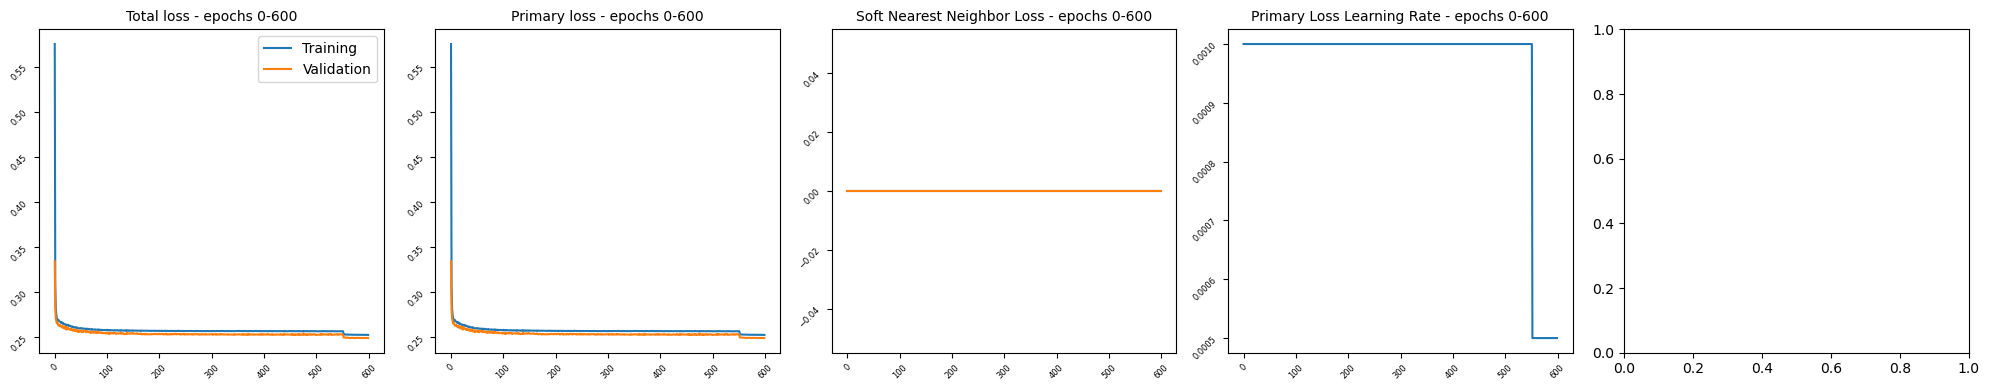

In [46]:
plot_train_history(model, start= 0, n_bins = 25)

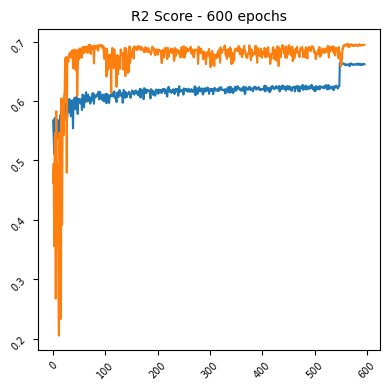

In [47]:
plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= 100, n_bins = 15)

In [ ]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Load model

In [ ]:
# ex_epochs = 200
# ex_mode = 'snnl'
ex_runmode = 'baseline'
ex_date = "20240616"
ex_title="snglOpt-025Ltnt"
# ex_title="secondTry"
# ex_title="dropout04"
# title="autoencoder"
# title='Xentropy'

In [ ]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [ ]:
filename = f"{model.name}_{args.runmode}_{ex_date}_{ex_title}_ep_{ex_epoch:03d}"   
filename = filelist[-1]
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

In [ ]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)
print(model.device)

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()


In [ ]:
model.optimizer.__dict__
print()

In [ ]:
model.scheduler.__dict__